In [19]:
import math as m
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Definitions

In [20]:
# user-defined parameters
NR_SIDES = 12    # base polygon
NR_LAYERS = 4   # no. of steps until top
S = 10          # length of polygon sides
# H = 30          # height of structure

# derived quantities
ALPHA = 2*m.pi/NR_SIDES                 # base polygonal angle
R = S/(2*m.sin(m.pi/NR_SIDES))          # base radius of circumscribed circle
A = S/(2*m.tan(m.pi/NR_SIDES))          # base polygon apothem
R_prime = R                             # vertical radius of circumscribed circle (special case of a sphere, for now)
BETA = 0.5*m.pi/NR_LAYERS               # vertical polygonal angle (simplified for special case)
S_prime = 2*R_prime*m.sin(0.5*BETA)     # vertical polygon side length
# A_prime = S_prime/(2*m.tan(m.pi/(NR_LAYERS))) # vertical polygon apothem (work in progress)


# R_prime = S*S / (2*m.sqrt(S*S - H*H))   # vertical radius of circumscribed circle
# BETA = 2*m.asin(S/(2*R_prime))          # vertical polygonal angle

print(f"{NR_SIDES=}\n{NR_LAYERS=}\n{S=}\n{ALPHA=}\n{R=}\n{A=}\n{R_prime=}\n{BETA=}\n{S_prime=}")
print(f"\nS=S_prime? {S==S_prime}")

NR_SIDES=12
NR_LAYERS=4
S=10
ALPHA=0.5235987755982988
R=19.318516525781366
A=18.660254037844386
R_prime=19.318516525781366
BETA=0.39269908169872414
S_prime=7.537711219777163

S=S_prime? False


## Constructing the object

In [21]:
def idx(i, j):
    """Index mapping between angles and cartesian points"""
    return i%NR_SIDES + NR_SIDES*j%(NR_SIDES*(NR_LAYERS+1))

def create_polys(angle_offset):
    # get all angular coordinates in a suitably formatted input array
    alphas = np.linspace(angle_offset, 2*np.pi + angle_offset, NR_SIDES, endpoint=False)
    betas = np.linspace(0, 0.5*np.pi, (NR_LAYERS+1), endpoint=True)
    X, Y = np.meshgrid(alphas, betas)
    angles = np.array([X.flatten(), Y.flatten()]).T

    # calculate actual (cartesian) coordinates of vertices
    xyz = np.zeros((angles.shape[0], 3))
    xyz[:, 0] = (R - R_prime*(1 - np.cos(angles[:,1])))*np.cos(angles[:,0])
    xyz[:, 1] = (R - R_prime*(1 - np.cos(angles[:,1])))*np.sin(angles[:,0])
    xyz[:, 2] = R_prime*np.sin(angles[:,1])

    # define polygon faces for the 3D plotter to work with
    polys = np.zeros((NR_SIDES*NR_LAYERS, 5, 3))

    k = 0
    for j in range(betas.shape[0]-1): # we have (NR_LAYERS+1) beta angles, but only NR_LAYERS faces in that direction
        for i in range(alphas.shape[0]):
            polys[k, 0, :] = xyz[idx(i, j), :]
            polys[k, 1, :] = xyz[idx(i+1, j), :]
            polys[k, 2, :] = xyz[idx(i+1, j+1), :]
            polys[k, 3, :] = xyz[idx(i, j+1), :]
            polys[k, 4, :] = polys[k, 0, :] # add first vertex again to close the loop
            
            k += 1
    
    return polys

In [22]:
# rotate object by angle
angle_offset = 0#.5*m.pi + 0.2*ALPHA

polys = create_polys(angle_offset)

## Projections

C:\Users\Jakob\AppData\Local\Temp\ipykernel_12584\203094416.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


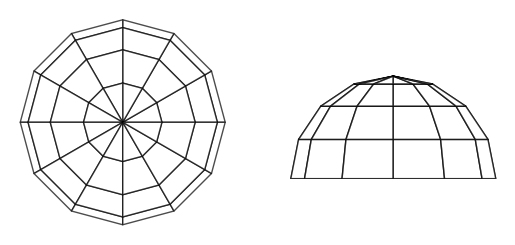

In [ ]:
fig, axs = plt.subplots(1,2)

# TOP VIEW PROJECTION
poly = PolyCollection(polys[:,:,:2], alpha=0.7)
poly.set_facecolor('white')
poly.set_edgecolor('black')

axs[0].add_collection(poly)

lim = 1.1*R
axs[0].set_xlim(-lim, lim)
axs[0].set_ylim(-lim, lim)
axs[0].set_aspect('equal')
# axs[0].axis('off')

# SIDE VIEW PROJECTION
poly = PolyCollection(polys[:,:,0::2], alpha=0.7)
poly.set_facecolor('white')
poly.set_edgecolor('black')
axs[1].add_collection(poly)

lim = 1.1*R
axs[1].set_xlim(-lim, lim)
axs[1].set_ylim(0, lim)
axs[1].set_aspect('equal')
# axs[1].axis('off')

fig.show()

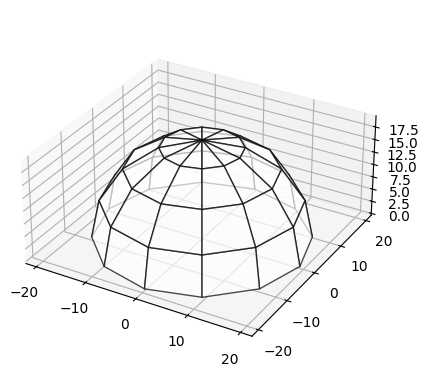

In [25]:
ax = plt.figure().add_subplot(projection='3d')

poly = Poly3DCollection(polys, alpha=0.7)

colours = 'white'
match colours:
    case 'white' : poly.set_facecolor(np.ones(polys.shape[0], dtype=str))
    # set facecolor values linearly between 0 and 1
    case 'linear b/w' : poly.set_facecolor(np.linspace(0, 1, polys.shape[0], dtype=str)),
    # for some reason const .99 is just dark gray
    case 'gray' : poly.set_facecolor(np.full(polys.shape[0], 0.99, dtype=str)),
    # random grayscale
    case 'gray_rnd' : poly.set_facecolor([str(x) for x in np.random.uniform(0,0.9,polys.shape[0])])
    # random colours
    case 'colour_rnd' : poly.set_facecolor(np.random.uniform(0, 1, (polys.shape[0], 3)))

poly.set_edgecolor('black')

ax.add_collection3d(poly)
ax.set_aspect('equal')
# ax.axis('off');

## Animated

In [7]:
from tqdm import tqdm
import os

In [35]:
frames = 20

# remove images from previous animation
for i in range(frames):
    try:
        os.remove(f'junk/im_{i}.png')
    except os.Exception.FileNotFoundError:
        continue

# generate and save all images
t = np.arange(0, ALPHA, ALPHA/frames)
for i, angle_offset in tqdm(list(enumerate(t))):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    poly = Poly3DCollection(create_polys(angle_offset), alpha=0.7)
    poly.set_facecolor('white')
    poly.set_edgecolor('black')

    ax.add_collection3d(poly)
    
    lim = 1.1*R
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    
    ax.set_aspect('equal')
    # ax.axis('off');
    
    plt.tight_layout()
    fig.savefig(f'junk/im_{i}.png')
    
    plt.close()

100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


In [36]:
# Use pillow to save all frames as an animation in a gif file
from PIL import Image

i = 0
images = []
while i < frames:
    try:
        images += [Image.open(f'junk/im_{i}.png')]
    except:
        break
    i += 1

images[0].save('junk/rotating.gif', save_all=True, append_images=images[1:], duration=int(1e3/frames), loop=0)

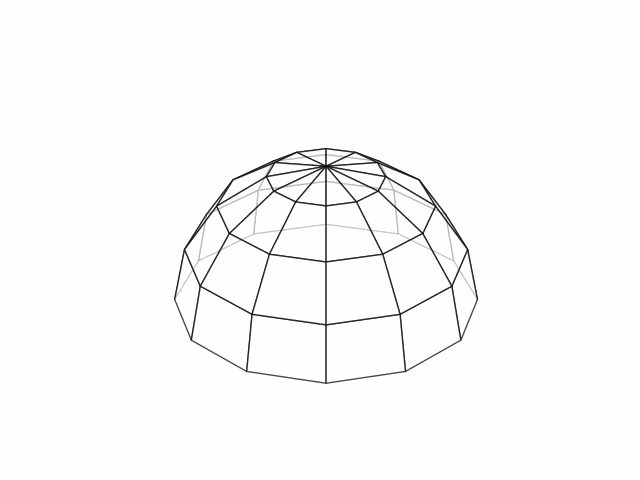

In [37]:
from IPython.display import Image
Image(filename='junk/rotating.gif')

## Pieces

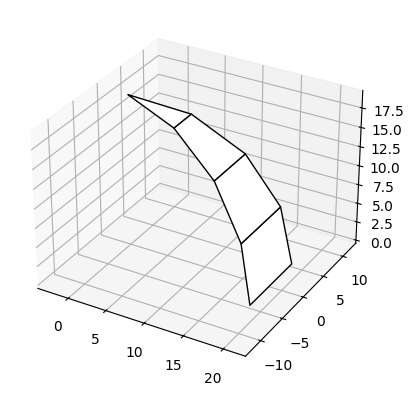

In [11]:
# we need one column of polygons, oriented perpendicularly to the x-axis
pieces = create_polys(-ALPHA/2)[::NR_SIDES,:,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

poly = Poly3DCollection(pieces)
poly.set_facecolor('white')
poly.set_edgecolor('black')

ax.add_collection3d(poly)
ax.axis('equal');

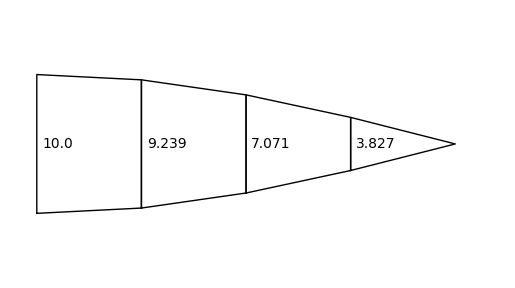

In [12]:
fig, ax = plt.subplots()

angle_offset = -0.5*ALPHA
for j in range(NR_LAYERS):
    # working radii
    r_1 = R - R_prime*(1 - m.cos(j*BETA))
    r_2 = R - R_prime*(1 - m.cos((j+1)*BETA))

    # working side lenghts
    s_1 = S*r_1/R
    s_2 = S*r_2/R

    # working apothema
    a_1 = j*S_prime
    a_2 = (j+1)*S_prime
    
    # piece
    points = np.array([[a_1, -0.5*s_1],
                       [a_2, -0.5*s_2],
                       [a_2, 0.5*s_2],
                       [a_1, 0.5*s_1],
                       [a_1, -0.5*s_1]])

    ax.plot(points[:,0], points[:,1],
            c='black', linewidth=1)
    ax.text(x = a_1 + 0.05*S_prime, 
            y = 0, 
            s = f"{round(s_1, 3)}", 
            va='center')

ax_lim = R

ax.set_xlim(-0.1*ax_lim, 1.75*ax_lim)
ax.set_ylim(-0.5*ax_lim, 0.5*ax_lim)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

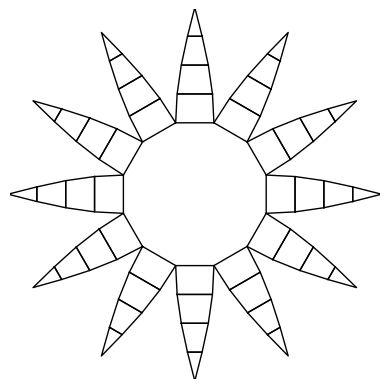

In [13]:
fig, ax = plt.subplots()

angle_offset = 0.5*m.pi + 0*ALPHA
for i in range(NR_SIDES):
    for j in range(NR_LAYERS):
        # working radii
        r_1 = R - R_prime*(1 - m.cos(j*BETA))
        r_2 = R - R_prime*(1 - m.cos((j+1)*BETA))

        # working side lenghts
        s_1 = S*r_1/R
        s_2 = S*r_2/R

        # working apothema
        a_1 = A + j*S_prime
        a_2 = A + (j+1)*S_prime
        
        # piece
        points = np.array([[a_1, -0.5*s_1],
                           [a_2, -0.5*s_2],
                           [a_2, 0.5*s_2],
                           [a_1, 0.5*s_1],
                           [a_1, -0.5*s_1]])

        # rotation
        rot_mat = np.array([[m.cos(i*ALPHA + angle_offset), -m.sin(i*ALPHA + angle_offset)],
                            [m.sin(i*ALPHA + angle_offset), m.cos(i*ALPHA + angle_offset)]])
        rot_points = np.matvec(rot_mat, points)

        ax.plot(rot_points[:,0], rot_points[:,1],
                c='black', linewidth=1)

ax_lim = R*2.5

ax.set_xlim(-ax_lim, ax_lim)
ax.set_ylim(-ax_lim, ax_lim)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

## R_prime =/= R

In [14]:
# user-defined parameters
NR_SIDES = 12    # base polygon
NR_LAYERS = 4   # no. of steps until top
S = 10          # length of polygon sides
H = 30          # height of structure
R_prime = 50    # vertical radius of circumscribed circle

# derived quantities
ALPHA = 2*m.pi/NR_SIDES                 # base polygonal angle
R = S/(2*m.sin(m.pi/NR_SIDES))          # base radius of circumscribed circle
A = S/(2*m.tan(m.pi/NR_SIDES))          # base polygon apothem
GAMMA = np.asin(H/R_prime)              # vertical circumscribed circular arc
BETA = GAMMA/NR_LAYERS                  # vertical polygonal angle
S_prime = 2*R_prime*m.sin(0.5*BETA)     # vertical polygon side length
# A_prime = S_prime/(2*m.tan(m.pi/(NR_LAYERS))) # vertical polygon apothem (work in progress)

print(f"{NR_SIDES=}\n{NR_LAYERS=}\n{S=}\n{H=}\n{R_prime=}\n{ALPHA=}\n{R=}\n{A=}\n{GAMMA=}\n{BETA=}\n{S_prime=}")

NR_SIDES=12
NR_LAYERS=4
S=10
H=30
R_prime=50
ALPHA=0.5235987755982988
R=19.318516525781366
A=18.660254037844386
GAMMA=np.float64(0.6435011087932844)
BETA=np.float64(0.1608752771983211)
S_prime=8.035092520470211


In [15]:
def idx(i, j):
    """Index mapping between angles and cartesian points"""
    return i%NR_SIDES + NR_SIDES*j%(NR_SIDES*(NR_LAYERS+1))

def create_polys(angle_offset):
    # get all angular coordinates in a suitably formatted input array
    alphas = np.linspace(angle_offset, 2*np.pi + angle_offset, NR_SIDES, endpoint=False)
    betas = np.linspace(0, GAMMA, (NR_LAYERS+1), endpoint=True)
    X, Y = np.meshgrid(alphas, betas)
    angles = np.array([X.flatten(), Y.flatten()]).T

    # calculate actual (cartesian) coordinates of vertices
    xyz = np.zeros((angles.shape[0], 3))
    xyz[:, 0] = (R - R_prime*(1 - np.cos(angles[:,1])))*np.cos(angles[:,0])
    xyz[:, 1] = (R - R_prime*(1 - np.cos(angles[:,1])))*np.sin(angles[:,0])
    xyz[:, 2] = R_prime*np.sin(angles[:,1])

    # define polygon faces for the 3D plotter to work with
    polys = np.zeros((NR_SIDES*NR_LAYERS, 5, 3))

    k = 0
    for j in range(betas.shape[0]-1): # we have (NR_LAYERS+1) beta angles, but only NR_LAYERS faces in that direction
        for i in range(alphas.shape[0]):
            polys[k, 0, :] = xyz[idx(i, j), :]
            polys[k, 1, :] = xyz[idx(i+1, j), :]
            polys[k, 2, :] = xyz[idx(i+1, j+1), :]
            polys[k, 3, :] = xyz[idx(i, j+1), :]
            polys[k, 4, :] = polys[k, 0, :] # add first vertex again to close the loop
            
            k += 1
    
    return polys

In [16]:
# rotate object by angle
angle_offset = 0#.5*m.pi + 0.2*ALPHA

polys = create_polys(angle_offset)

C:\Users\Jakob\AppData\Local\Temp\ipykernel_12584\1276988354.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


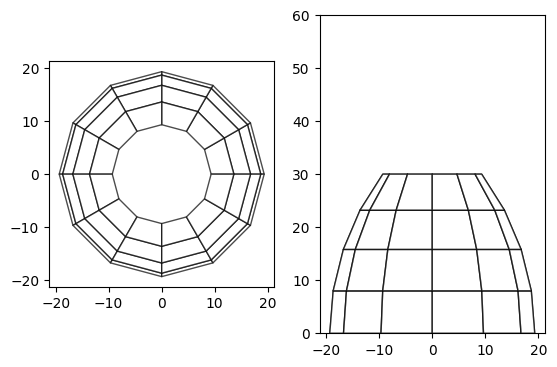

In [17]:
fig, axs = plt.subplots(1,2)

# TOP VIEW PROJECTION
poly = PolyCollection(polys[:,:,:2], alpha=0.7)
poly.set_facecolor('white')
poly.set_edgecolor('black')

axs[0].add_collection(poly)

lim = 1.1*R
axs[0].set_xlim(-lim, lim)
axs[0].set_ylim(-lim, lim)
axs[0].set_aspect('equal')

# SIDE VIEW PROJECTION
poly = PolyCollection(polys[:,:,0::2], alpha=0.7)
poly.set_facecolor('white')
poly.set_edgecolor('black')
axs[1].add_collection(poly)

lim = 1.1*R
axs[1].set_xlim(-lim, lim)
axs[1].set_ylim(0, 2*H)
axs[1].set_aspect('equal')

fig.show()